In [29]:
!jt -t onedork

In [1]:
import warnings
warnings.filterwarnings('ignore')

<img align="left" src="https://lever-client-logos.s3.amazonaws.com/864372b1-534c-480e-acd5-9711f850815c-1524247202159.png" width=200>
<br></br>
<br></br>

# Topic Modeling
## *Data Science Unit 4 Sprint 1 Lesson 4*
On Monday we talked about summarizing your documents using just token counts. Today, we're going to learn about a much more sophiscated approach - learning 'topics' from documents. Topics are a latent structure. They are not directly observable in the data, but we know they're there by reading them.

> **latent**: existing but not yet developed or manifest; hidden or concealed.

## Use Cases
Primary use case: what the hell are your documents about? Who might want to know that in industry - 
* Identifing common themes in customer reviews
* Discoverying the needle in a haystack 
* Monitoring communications (Email - State Department) 

## Learning Objectives
*At the end of the lesson you should be able to:*
* <a href="#p1">Part 1</a>: Describe how an LDA Model works
* <a href="#p2">Part 2</a>: Estimate a LDA Model with Gensim
* <a href="#p3">Part 3</a>: Interpret LDA results
* <a href="#p4">Part 4</a>: Select the appropriate number of topics

## Part 1: Latent Dirchilet Allocation (LDA) Models
<a id="#p1"></a>

LDA is a "generative probabilistic model". 

Let's play with a modoel available [here](https://lettier.com/projects/lda-topic-modeling/)

## Part 2: Estimating LDA Models with Gensim
<a id="#p1"></a>

### A Litterary Introduction: *Jane Austen V. Charlotte Bronte*
Despite being born nearly forty years apart, modern fans often pit Jane Austen & Charlotte Bronte against one another in a battle for litterary  supremacy. The battle centers around the topics of education for women, courting, and marriage. The authors' similiar backgrounds naturally draw comparisons, but the modern fascination is probably due to novelility of British women publishing novels during the early 19th century. 

Can we help close a litterary battle for supremacy and simply acknowledge that the authors addressed different topics and deserve to be acknowledged as excellent authors each in their own right?

We're going to apply Latent Dirichlet Allocation a machine learning alogrithm for topic modeling to each of the author's novels to compare the distribution of topics in their novels.

In [2]:
import numpy as np
import gensim
import os
import re

from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from gensim import corpora

from gensim.models.ldamulticore import LdaMulticore

import pandas as pd

### Novel Data
I grabbed the novel data pre-split into a bunch of smaller chuncks

In [3]:
path = './data/austen-brontë-split'

### Text Preprocessing
**Challenge**: update the function `tokenize` with any technique you have learned so far this week. 

In [4]:
titles = [t[:-4] for t in os.listdir(path)]

In [5]:
titles[:5]

['CBronte_Jane0148',
 'CBronte_Jane0159',
 'Austen_Pride0050',
 'CBronte_Villette0141',
 'CBronte_Villette0041']

In [6]:
STOPWORDS = set(STOPWORDS).union(set(['said', 'mr', 'mrs']))

def tokenize(text):
    return [token for token in simple_preprocess(text) if token not in STOPWORDS]

In [7]:
tokenize("Hello World! This a test of the tokenization method")

['hello', 'world', 'test', 'tokenization', 'method']

### Author DataFrame


In [8]:
df = pd.DataFrame(index=titles)

In [9]:
df.head()

""
CBronte_Jane0148
CBronte_Jane0159
Austen_Pride0050
CBronte_Villette0141
CBronte_Villette0041


In [10]:
df['author'] = df.reset_index()['index'].apply(lambda x: x.split('_')[0]).tolist()
df['book'] = df.reset_index()['index'].apply(lambda x: x.split('_')[1][:-4]).tolist()
df['section'] = df.reset_index()['index'].apply(lambda x: x[-4:]).tolist()
df['section'] = df['section'].astype('int')

In [11]:
df['author'] = df['author'].map({'Austen':1, 'CBronte':0})

In [12]:
df.author.value_counts()

0    441
1    372
Name: author, dtype: int64

### Streaming Documents
Here we use a new pythonic thingy: the `yield` statement in our fucntion. This allows us to iterate over a bunch of documents without actually reading them into memory. You can see how we use this fucntion later on. 

In [13]:
def doc_stream(path):
    for f in os.listdir(path):
        with open(os.path.join(path,f)) as t:
            text = t.read().strip('\n')
            tokens = tokenize(str(text))
            yield tokens

### Gensim LDA Topic Modeling

In [14]:
# A Dictionary Representation of all the words in our corpus
id2word = corpora.Dictionary(doc_stream(path))

In [15]:
id2word.doc2bow(tokenize("This is a sample message Darcy England England England"))

[(3051, 3), (5390, 1), (6308, 1), (12131, 1)]

In [16]:
import sys
sys.getsizeof(id2word)

56

In [17]:
len(id2word.keys())

22096

In [18]:
# Let's remove extreme values from the dataset
id2word.filter_extremes(no_below=10, no_above=0.75)

In [19]:
len(id2word.keys())

4922

In [20]:
# a bag of words(bow) representation of our corpus
# Note: we haven't actually read any text into memory here
corpus = [id2word.doc2bow(text) for text in doc_stream(path)]

In [21]:
lda = LdaMulticore(corpus=corpus,
                   id2word=id2word,
                   random_state=723812,
                   num_topics = 15,
                   passes=10,
                   workers=4
                  )

In [23]:
lda.print_topics()

[(0,
  '0.015*"weston" + 0.013*"emma" + 0.010*"elton" + 0.010*"miss" + 0.009*"woodhouse" + 0.007*"thing" + 0.007*"churchill" + 0.006*"great" + 0.006*"knightley" + 0.006*"think"'),
 (1,
  '0.014*"elizabeth" + 0.010*"darcy" + 0.009*"jane" + 0.008*"know" + 0.007*"bennet" + 0.007*"bingley" + 0.007*"sister" + 0.006*"miss" + 0.006*"think" + 0.005*"wickham"'),
 (2,
  '0.010*"lucy" + 0.007*"elinor" + 0.007*"think" + 0.006*"edward" + 0.006*"know" + 0.006*"mother" + 0.004*"thought" + 0.004*"john" + 0.004*"sure" + 0.004*"dashwood"'),
 (3,
  '0.023*"bessie" + 0.013*"reed" + 0.009*"miss" + 0.009*"like" + 0.007*"long" + 0.007*"room" + 0.005*"gateshead" + 0.005*"came" + 0.004*"georgiana" + 0.004*"went"'),
 (4,
  '0.009*"john" + 0.009*"st" + 0.007*"madame" + 0.006*"like" + 0.005*"day" + 0.005*"diana" + 0.005*"heart" + 0.004*"mary" + 0.004*"saw" + 0.004*"long"'),
 (5,
  '0.023*"marianne" + 0.021*"elinor" + 0.011*"willoughby" + 0.010*"sister" + 0.006*"jennings" + 0.006*"mother" + 0.005*"know" + 0.005*"d

In [24]:
words = [re.findall(r'"([^"]*)"',t[1]) for t in lda.print_topics()]

In [25]:
topics = [' '.join(t[0:5]) for t in words]

In [26]:
print(topics[0])

weston emma elton miss woodhouse


## Part 3: Interpret LDA Results
<a id="#p3"></a>

### Topic Distance Visualization

In [27]:
import pyLDAvis.gensim

pyLDAvis.enable_notebook()

/home/seek/anaconda3/envs/U4-S1-NLP/lib/python3.7/site-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Iterable


In [28]:
pyLDAvis.gensim.prepare(lda, corpus, id2word)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
7     -0.107208  0.003788       1        1  17.387558
8     -0.119995 -0.002332       2        1  13.931966
10     0.082974  0.053612       3        1  13.850093
1      0.101910 -0.030762       4        1  11.110392
9     -0.098773 -0.003519       5        1  10.844906
2      0.030287  0.017636       6        1   9.492128
5      0.073381 -0.023829       7        1   6.402812
4     -0.122836  0.001788       8        1   3.899554
0      0.092427  0.096239       9        1   3.047393
12     0.114644 -0.065387      10        1   2.545546
6      0.085644 -0.141104      11        1   2.165141
13     0.079128  0.110843      12        1   2.133390
3     -0.124531 -0.020255      13        1   1.624166
11    -0.038348 -0.052942      14        1   0.892752
14    -0.048704  0.056223      15        1   0.672212, topic_info=     Category         Freq        Term        Total  loglift  logprob
1493  Default   832.000000        emma   832.000000  30.0000  30.0000
591   Default   641.000000   elizabeth   641.000000  29.0000  29.0000
2241  Default   670.000000      elinor   670.000000  28.0000  28.0000
2258  Default   562.000000    marianne   562.000000  27.0000  27.0000
1973  Default   499.000000     harriet   499.000000  26.0000  26.0000
154   Default  1527.000000        miss  1527.000000  25.0000  25.0000
121   Default  1428.000000        know  1428.000000  24.0000  24.0000
3750  Default   415.000000       darcy   415.000000  23.0000  23.0000
133   Default  1337.000000        like  1337.000000  22.0000  22.0000
2033  Default   421.000000      weston   421.000000  21.0000  21.0000
546   Default   323.000000      bennet   323.000000  20.0000  20.0000
404   Default   937.000000        jane   937.000000  19.0000  19.0000
3977  Default   307.000000     bingley   307.000000  18.0000  18.0000
1492  Default   370.000000       elton   370.000000  17.0000  17.0000
632   Default   627.000000        lady   627.000000  16.0000  16.0000
493   Default   776.000000       thing   776.000000  15.0000  15.0000
116   Default   617.000000        john   617.000000  14.0000  14.0000
695   Default   607.000000         sir   607.000000  13.0000  13.0000
2881  Default   377.000000   knightley   377.000000  12.0000  12.0000
238   Default  1302.000000       think  1302.000000  11.0000  11.0000
2273  Default   587.000000      sister   587.000000  10.0000  10.0000
1318  Default   583.000000        dear   583.000000   9.0000   9.0000
1015  Default   416.000000      madame   416.000000   8.0000   8.0000
1600  Default   301.000000   woodhouse   301.000000   7.0000   7.0000
456   Default   899.000000        room   899.000000   6.0000   6.0000
821   Default   358.000000        lucy   358.000000   5.0000   5.0000
639   Default   942.000000        long   942.000000   4.0000   4.0000
3467  Default   217.000000  willoughby   217.000000   3.0000   3.0000
206   Default   925.000000       shall   925.000000   2.0000   2.0000
2250  Default   227.000000    jennings   227.000000   1.0000   1.0000
...       ...          ...         ...          ...      ...      ...
2255  Topic15     5.893547        lord    76.475166   2.4392  -5.7903
3627  Topic15     2.577550     details    28.207689   2.6096  -6.6173
2764  Topic15     3.154404       curls    37.895302   2.5163  -6.4154
181   Topic15    14.185232        poor   384.138611   1.7035  -4.9120
1306  Topic15     2.543353     capital    28.191025   2.5968  -6.6307
177   Topic15     8.071677        papa   171.799728   1.9444  -5.4758
1386  Topic15     9.012142      pretty   233.462250   1.7479  -5.3656
121   Topic15    23.151127        know  1428.762451   0.8798  -4.4221
1590  Topic15     5.934744       uncle   151.589828   1.7620  -5.7833
1670  Topic15     3.796964       mamma    66.553360   2.1385  -6.2300
174   Topic15    11.341209          oh   558.961365   1.1047  -5.1357
133   Topic15    17.561409   

### Overall Model / Documents

In [62]:
lda[corpus[0]]

[(3, 0.40677), (7, 0.14902128), (10, 0.44191644)]

In [63]:
distro = [lda[d] for d in corpus]

In [64]:
distro[0]

[(3, 0.40677533), (7, 0.1490287), (10, 0.44190374)]

In [69]:
def update(doc):
        d_dist = {k:0 for k in range(0,15)}
        for t in doc:
            d_dist[t[0]] = t[1]
        return d_dist
    
new_distro = [update(d) for d in distro]

In [67]:
d_dist = {k:0 for k in range(0,15)}

In [68]:
d_dist

{0: 0,
 1: 0,
 2: 0,
 3: 0,
 4: 0,
 5: 0,
 6: 0,
 7: 0,
 8: 0,
 9: 0,
 10: 0,
 11: 0,
 12: 0,
 13: 0,
 14: 0}

In [72]:
df = pd.DataFrame.from_records(new_distro, index=titles)
df.columns = topics
df['author'] = df.reset_index()['index'].apply(lambda x: x.split('_')[0]).tolist()

In [73]:
df.head()

,marianne elinor willoughby sister jennings,miss reed bessie jane sir,marianne elinor dashwood john mother,emma miss harriet weston elton,night bretton like saw long,elizabeth collins charlotte lucas jane,rochester jane door sir room,like thought day know long,miss ingram eshton temple lady,madame door like room graham,elizabeth miss know sister think,papa graham home like man,bessie door fairfax shall know,bingley miss darcy elizabeth bennet,know sir think jane rochester,author
Austen_Emma0026,0.0,0.0,0.0,0.406775,0.000000,0.0,0.0,0.149029,0.0,0.000000,0.441904,0.0,0.0,0.000000,0.000000,Austen
Austen_Emma0032,0.0,0.0,0.0,0.788514,0.000000,0.0,0.0,0.038802,0.0,0.000000,0.170351,0.0,0.0,0.000000,0.000000,Austen
CBronte_Villette0086,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.673504,0.0,0.000000,0.000000,0.0,0.0,0.030139,0.294085,CBronte
CBronte_Jane0099,0.0,0.0,0.0,0.000000,0.997287,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,CBronte
CBronte_Villette0092,0.0,0.0,0.0,0.028774,0.000000,0.0,0.0,0.917771,0.0,0.051475,0.000000,0.0,0.0,0.000000,0.000000,CBronte


In [74]:
df.groupby('author').mean()

,marianne elinor willoughby sister jennings,miss reed bessie jane sir,marianne elinor dashwood john mother,emma miss harriet weston elton,night bretton like saw long,elizabeth collins charlotte lucas jane,rochester jane door sir room,like thought day know long,miss ingram eshton temple lady,madame door like room graham,elizabeth miss know sister think,papa graham home like man,bessie door fairfax shall know,bingley miss darcy elizabeth bennet,know sir think jane rochester
author,,,,,,,,,,,,,,,
Austen,0.070843,0.000342,0.069807,0.303502,0.000222,0.026562,0.002335,0.011799,0.000283,0.000843,0.445328,0.000000,0.001635,0.060403,0.003339
CBronte,0.000654,0.036233,0.000536,0.002200,0.045220,0.000000,0.073837,0.619881,0.019861,0.049955,0.016087,0.010788,0.012215,0.005559,0.104051


## Can we see if one of the authors focus more on men than women? - Ned

*  Use Spacy for text prepocessing
*  Extract the Named Entities from the documents using Spacy (command is fairly straight forward)
*  Create unique list of names from the authors (you'll find that there are different types of named entities not all people)
*  Label the names with genders (can you this by hand or you use the US census name lists)
*  Customize your processing to replace the proper name with your gender from the previous step's lookup table
*  Then follow the rest of the LDA flow


## Part 4: Selecting the Number of Topics
<a id="#p4"></a>

In [75]:
from gensim.models.coherencemodel import CoherenceModel

def compute_coherence_values(dictionary, corpus, path, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    path : path to input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        stream = doc_stream(path)
        model = LdaMulticore(corpus=corpus, num_topics=num_topics, id2word=id2word, workers=4)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=stream, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [76]:
# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=id2word, 
                                                        corpus=corpus, 
                                                        path=path, 
                                                        start=2, 
                                                        limit=40, 
                                                        step=6)

/Users/jonathansokoll/anaconda3/envs/U4-S1-NLP/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/Users/jonathansokoll/anaconda3/envs/U4-S1-NLP/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/Users/jonathansokoll/anaconda3/envs/U4-S1-NLP/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator))

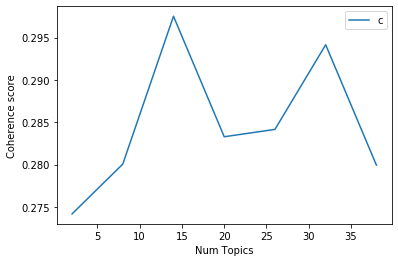

In [79]:
# Show graph
import matplotlib.pyplot as plt

limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [80]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.2742
Num Topics = 8  has Coherence Value of 0.2801
Num Topics = 14  has Coherence Value of 0.2975
Num Topics = 20  has Coherence Value of 0.2833
Num Topics = 26  has Coherence Value of 0.2842
Num Topics = 32  has Coherence Value of 0.2941
Num Topics = 38  has Coherence Value of 0.2799


In [81]:
import spacy

nlp = spacy.load('en_core_web_lg')

/Users/jonathansokoll/anaconda3/envs/U4-S1-NLP/lib/python3.7/site-packages/thinc/neural/train.py:3: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from .optimizers import Adam, SGD, linear_decay
/Users/jonathansokoll/anaconda3/envs/U4-S1-NLP/lib/python3.7/site-packages/thinc/check.py:1: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import defaultdict, Sequence, Sized, Iterable, Callable
/Users/jonathansokoll/anaconda3/envs/U4-S1-NLP/lib/python3.7/site-packages/thinc/check.py:1: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import defaultdict, Sequence, Sized, Iterable, Callable


In [83]:
test = "Ned ask me a question about England today."

In [84]:
doc = nlp(test)

for token in doc:
    print(token.text, token.lemma_, token.pos_)

Ned ned PROPN
ask ask VERB
me -PRON- PRON
a a DET
question question NOUN
about about ADP
England england PROPN
today today NOUN
. . PUNCT


In [85]:
for ent in doc.ents:
    print(ent.text, ent.label_)

Ned PERSON
England GPE
today DATE


In [88]:
def doc_stream(path):
    for f in os.listdir(path):
        with open(os.path.join(path,f)) as t:
            text = t.read().strip('\n')
            yield text

def get_people(docstream):
    
    ppl = []
    in
    for d in docstream:
        
        doc = nlp(d)
        
        for ent in doc.ents:
            
            if ent.label_ == "PERSON":
                ppl.append(ent.text)
                
    return set(ppl)

In [89]:
people = get_people(doc_stream(path))

In [92]:
people = pd.Series(list(people))

In [94]:
people.head(50)

0                     Prudence
1           another Lucy Snowe
2                 Lydia Bennet
3                       J.E.\n
4                   Lucy Snowe
5                      \nJesus
6              Stilton\ncheese
7                  William Cox
8                       Paynim
9                    Bon\nsoir
10                       Ruben
11                    St. Matt
12                  Will Polly
13            Lady Middleton's
14               Bill Oliver's
15                    Robert\n
16                        Chut
17                   M. Paul's
18                Sarah Martha
19                      Trista
20            Ginevra Fanshawe
21                    Ferndean
22                   \nFanny's
23                   Scotchman
24                  \nEnscombe
25      John\nKnightley)--your
26       Cette malle est a moi
27                Brocklehurst
28                        Kint
29               \nGeorgette's
30                    M. Brown
31                \ndeceit!--I
32      

## Additional Resources
## Resources

* [Gensim](https://radimrehurek.com/gensim/): Python package for topic modeling, nlp, word vectorization, and few other things. Well maintained and well documented.
* [Topic Modeling with Gensim](http://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/#11createthedictionaryandcorpusneededfortopicmodeling): A kind of cookbook for LDA with gensim. Excellent overview, but the you need to be aware of missing import statements and assumed prior knowledge.
* [Chinese Restuarant Process](https://en.wikipedia.org/wiki/Chinese_restaurant_process): That really obscure stats thing I mentioned... 
* [PyLDAvis](https://github.com/bmabey/pyLDAvis): Library for visualizing the topic model and performing some exploratory work. Works well. Has a direct parrell implementation in R as well. 
* [Rare Technologies](https://rare-technologies.com/): The people that made & maintain gensim and a few other libraries.
* [Jane Austen v. Charlotte Bronte](https://www.literaryladiesguide.com/literary-musings/jane-austen-charlotte-bronte-different-alike/)